In [41]:
# Step 1: Import Libraries
%pip install yfinance --quiet
%pip install plotly --quiet
%pip install statsmodels --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
# Step 2: Load the Stock Data
stock = "ABCAPITAL.NS"
data = yf.download(stock, start="2024-01-01", end="2024-09-30")


# Display the first few rows of the data
data.head()


C:\Users\vikas\AppData\Local\Temp\ipykernel_24168\968951104.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ABCAPITAL.NS,ABCAPITAL.NS,ABCAPITAL.NS,ABCAPITAL.NS,ABCAPITAL.NS
Date,,,,,
2024-01-01,166.050003,169.000000,165.500000,169.000000,4244834
2024-01-02,170.600006,171.600006,164.399994,166.800003,12968451
2024-01-03,170.399994,172.350006,169.250000,171.300003,6963477
2024-01-04,174.100006,174.600006,170.600006,171.699997,7927230
2024-01-05,175.100006,179.199997,173.000000,175.000000,14396150


In [43]:
# Step 3: Data Preparation
# 3.1 Check for Stationarity
result = adfuller(data['Close'].dropna())
print(f'p-value: {result[1]}')

# If p-value > 0.05, the data is non-stationary and needs differencing
# 3.2 Transform Data if Necessary
if result[1] > 0.05:
    data['Close_diff'] = data['Close'].diff().dropna()
    # Recheck stationarity after differencing
    result_diff = adfuller(data['Close_diff'].dropna())
    print(f'p-value after differencing: {result_diff[1]}')

p-value: 0.4261036161985823
p-value after differencing: 1.1530023965442054e-26


In [44]:
# Step 4: Calculate Moving Averages
# Calculate Simple Moving Averages (SMA)
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Calculate Weighted Moving Averages (WMA)
def weighted_moving_average(series, window_size):
    weights = np.arange(1, window_size + 1)
    return series.rolling(window=window_size).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

data['WMA_5'] = weighted_moving_average(data['Close'], window_size=5)
data['WMA_20'] = weighted_moving_average(data['Close'], window_size=20)

# Display the first few rows with SMAs and WMAs
data[['Close', 'SMA_5', 'SMA_20', 'WMA_5', 'WMA_20']].head()


Price,Close,SMA_5,SMA_20,WMA_5,WMA_20
Ticker,ABCAPITAL.NS,,,,
Date,,,,,
2024-01-01,166.050003,NaN,NaN,NaN,NaN
2024-01-02,170.600006,NaN,NaN,NaN,NaN
2024-01-03,170.399994,NaN,NaN,NaN,NaN
2024-01-04,174.100006,NaN,NaN,NaN,NaN
2024-01-05,175.100006,171.250003,NaN,172.690003,NaN


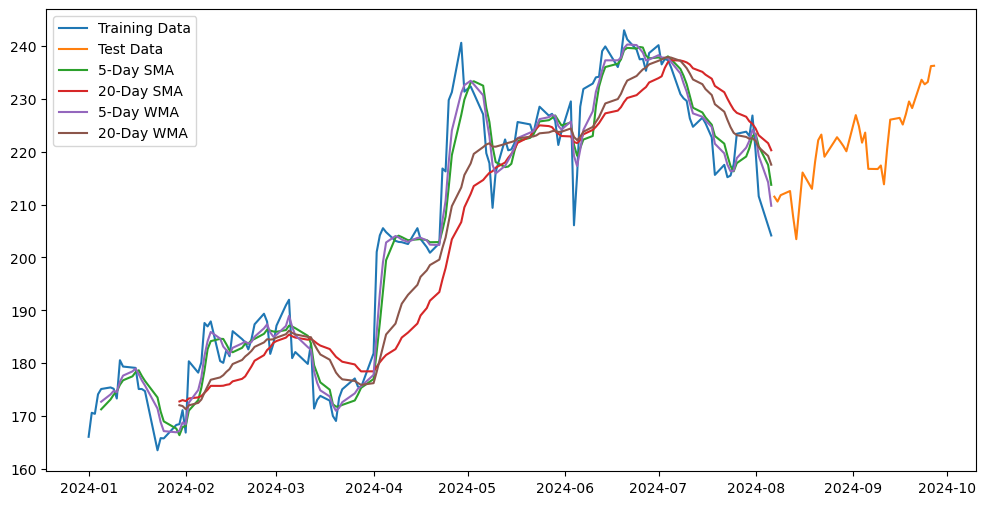

In [45]:
# Step 5: Split the Data into Training and Test Sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Plot the training and test data with moving averages
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Test Data')
plt.plot(train['SMA_5'], label='5-Day SMA')
plt.plot(train['SMA_20'], label='20-Day SMA')
plt.plot(train['WMA_5'], label='5-Day WMA')
plt.plot(train['WMA_20'], label='20-Day WMA')
plt.legend(loc='best')
plt.show()


In [46]:
# Step 6: Model Fitting and Forecasting
# 6.1 Forecasting with Moving Average
last_observations = data['Close'][-5:]
forecast = np.mean(last_observations)
print(f'Forecasted value: {forecast}')


Forecasted value: 234.44400024414062


In [47]:
# Step 7: Model Evaluation
# 7.1 Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
def evaluate_moving_average(test, window_size):
    predictions = test['Close'].shift(1).rolling(window=window_size).mean()
    mse = mean_squared_error(test['Close'][window_size:], predictions[window_size:])
    rmse = np.sqrt(mse)
    return mse, rmse

mse_5, rmse_5 = evaluate_moving_average(test, 5)
mse_20, rmse_20 = evaluate_moving_average(test, 20)
print(f'Mean Squared Error for 5-Day MA: {mse_5}')
print(f'Root Mean Squared Error for 5-Day MA: {rmse_5}')
print(f'Mean Squared Error for 20-Day MA: {mse_20}')
print(f'Root Mean Squared Error for 20-Day MA: {rmse_20}')


Mean Squared Error for 5-Day MA: 25.986942142191687
Root Mean Squared Error for 5-Day MA: 5.097738924483254
Mean Squared Error for 20-Day MA: 50.21187053750333
Root Mean Squared Error for 20-Day MA: 7.086033484080027


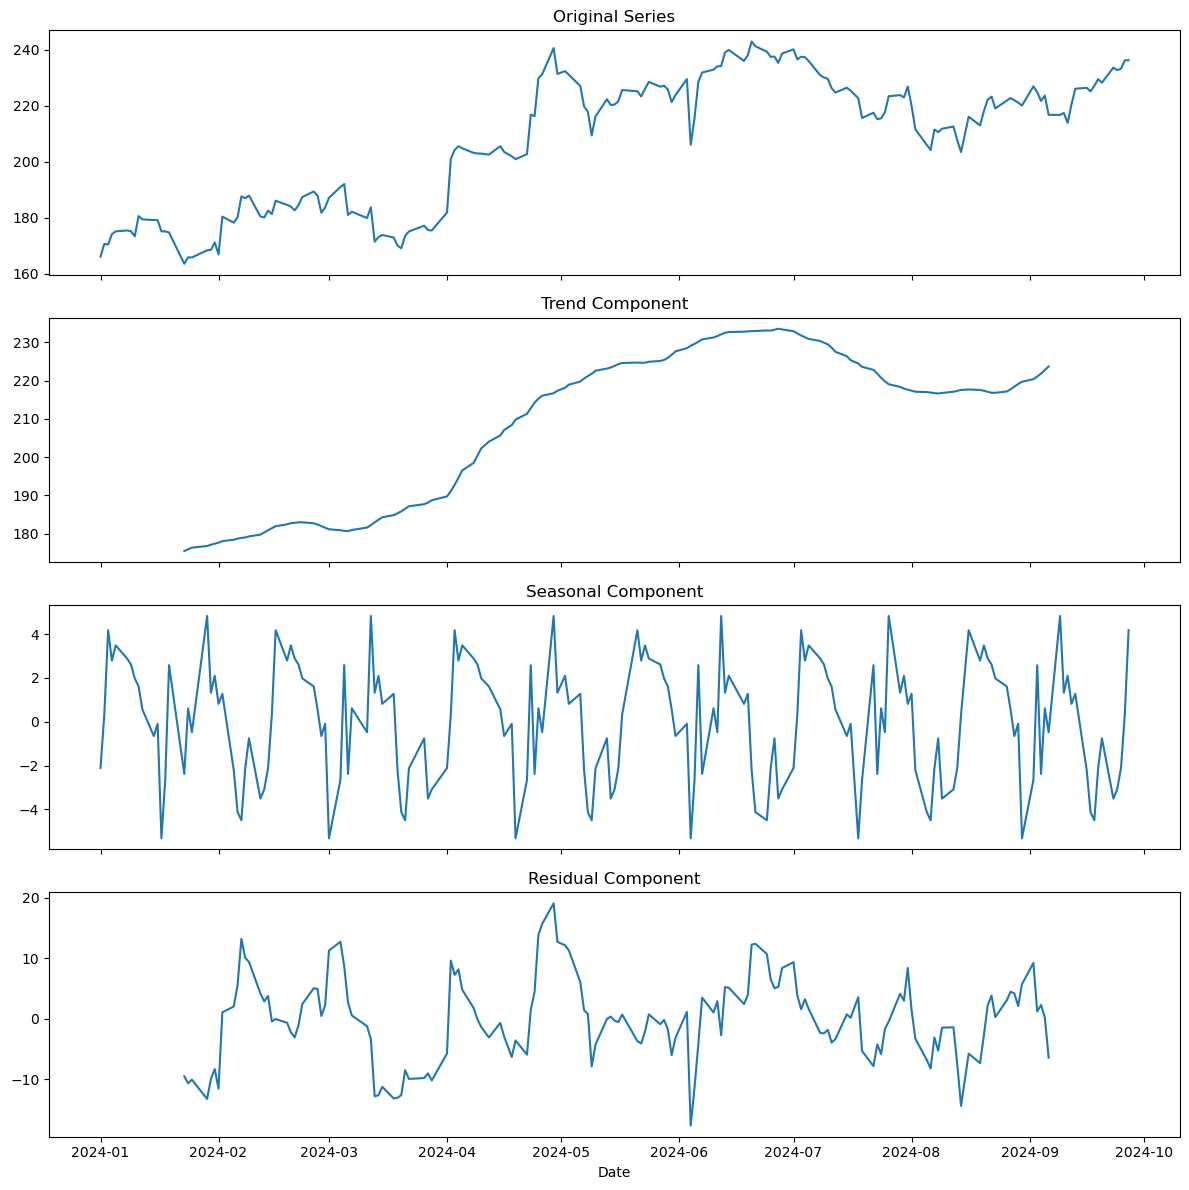

In [48]:
# Step 8: Data Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series data
decomposition = seasonal_decompose(data['Close'].dropna(), model='additive', period=30)

# Plot the decomposition
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Original Series
axs[0].plot(decomposition.observed)
axs[0].set_title('Original Series')

# Trend Component
axs[1].plot(decomposition.trend)
axs[1].set_title('Trend Component')

# Seasonal Component
axs[2].plot(decomposition.seasonal)
axs[2].set_title('Seasonal Component')

# Residual Component
axs[3].plot(decomposition.resid)
axs[3].set_title('Residual Component')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Use trend='add' for additive trend (Holt's method)
es_model = ExponentialSmoothing(train['Close'], trend='add', seasonal=None)
es_fitted = es_model.fit()
es_forecast = es_fitted.forecast(steps=len(test))
es_forecast.index = test.index

# Calculate confidence intervals (optional, for plotting)
forecast_se = np.std(es_fitted.resid)
ci_upper = es_forecast + 1.96 * forecast_se
ci_lower = es_forecast - 1.96 * forecast_se

c:\Users\vikas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\vikas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\vikas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [50]:
print("First 10 forecast values:", es_forecast.head(10).values)
print("First 10 test values:", test['Close'].head(10).values)

First 10 forecast values: [204.51373473 204.77620739 205.03868004 205.3011527  205.56362536
 205.82609801 206.08857067 206.35104333 206.61351599 206.87598864]
First 10 test values: [[211.52000427]
 [210.58999634]
 [211.80000305]
 [212.58999634]
 [207.69000244]
 [203.47000122]
 [216.08999634]
 [213.        ]
 [218.11000061]
 [222.21000671]]


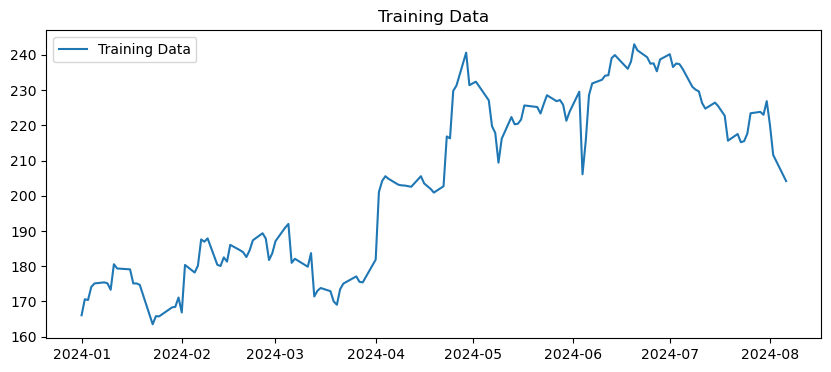

In [51]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train['Close'], label='Training Data')
plt.title('Training Data')
plt.legend()
plt.show()

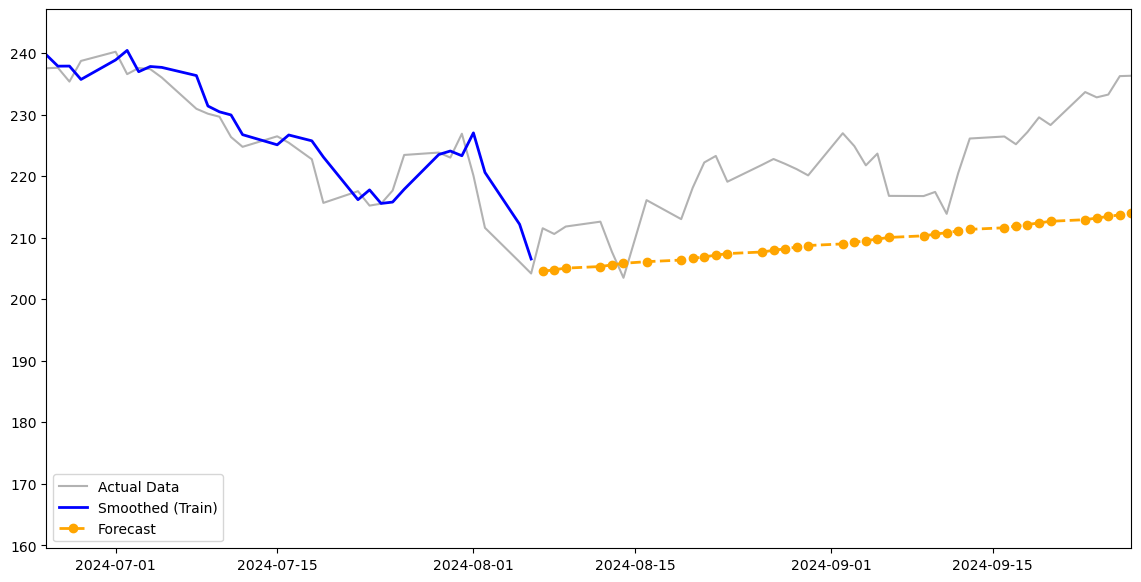

In [52]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Actual Data', color='gray', alpha=0.6)
plt.plot(train.index, es_fitted.fittedvalues, label='Smoothed (Train)', color='blue', linewidth=2)
plt.plot(test.index, es_forecast, label='Forecast', color='orange', linestyle='--', marker='o', linewidth=2)
plt.legend()
plt.xlim(train.index[-30], test.index[-1])  # Show only last 30 train days + test period
plt.show()

In [53]:
# Step 10: Create Interactive Charts with Plotly

# Plotly Interactive Candlestick Chart with SMA and WMA
fig = go.Figure()

# Add candlestick chart
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'],
                             name='Candlestick'))

# Add moving averages
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_5'], mode='lines', name='5-Day SMA'))
fig.add_trace(go.Scatter(x=data.index, y=data['SMA_20'], mode='lines', name='20-Day SMA'))
fig.add_trace(go.Scatter(x=data.index, y=data['WMA_5'], mode='lines', name='5-Day WMA'))
fig.add_trace(go.Scatter(x=data.index, y=data['WMA_20'], mode='lines', name='20-Day WMA'))

# Update layout for better presentation
fig.update_layout(title='IRFC Candlestick Chart with SMA and WMA',
                  xaxis_title='Date',
                  yaxis_title='Price (INR)',
                  legend=dict(x=0, y=1),
                  hovermode='x')

fig.show()


# Conclusion:
This notebook provides a comprehensive guide to building and evaluating a Moving Average Model using real-time stock data. It includes calculations for Simple Moving Averages (SMA), Weighted Moving Averages (WMA), and data decomposition to understand time series components. It also includes interactive Plotly charts for visualization and evaluation of the model’s performance.